# Setting everything up

In [1]:
import numpy as np
from numpy.polynomial.legendre import leggauss
from numpy.random import default_rng
from scipy.special import eval_legendre
from scipy.linalg import svd, norm
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from scipy.stats import multivariate_normal
import pandas as pd

In [2]:
# Monte Carlo integrator for L2‐error
def relative_L2_error(f_est, f_true, sample_points, domain_vol):
    M = sample_points.shape[0]
    est_vals  = f_est(sample_points)
    est_vals[est_vals < 0] = 0
    true_vals = f_true(sample_points)
    sq_diff = (est_vals - true_vals)**2
    sq_true = true_vals**2
    # integral ≈ domain_vol * average
    int_diff = domain_vol * np.mean(sq_diff)
    int_true = domain_vol * np.mean(sq_true)
    return np.sqrt(int_diff / int_true)

In [3]:
# just generates Gaussian data scaled to [-1,1]
def generate_scaled_data(N, d, seed=42):
    np.random.seed(seed)
    
    # Step 1: Sample from multivariate normal
    Z = np.random.randn(N, d)  # standard normal
    
    # Step 2: Scale each coordinate to [-1, 1]
    Z_min = Z.min(axis=0)
    Z_max = Z.max(axis=0)
    Z_scaled = 2 * (Z - Z_min) / (Z_max - Z_min) - 1  # linear transform to [-1, 1]
    
    return Z_scaled

In [4]:
def generate_gaussian(N, mean, std, seed=None):
    """
    Generate N points from a Gaussian with specified means and std deviations
    Eliminates points outside of [-1,1] to ensure the Legendre basis works well
    
    Returns:
        array of shape (N,) with Gaussian distribution
    """
    if seed is not None:
        np.random.seed(seed)
        
    vals = []
    while len(vals) < N:
        x = np.random.normal(loc=mean, scale=std, size=N)
        mask = (x >= -1) & (x <= 1)
        vals.extend(x[mask])
        
    return np.array(vals[:N])

In [5]:
def d_dim_gaussian_density(means, stds, grid_size=100, i=0, j=1):
    """
    Generates the density of a d-dimensional axis-aligned Gaussian,
    and returns a 2D slice over dimensions i and j for visualization.
    """
    d = len(means)
    assert len(stds) == d
    assert 0 <= i < d and 0 <= j < d and i != j

    # Grid over [-1, 1]^d
    x = np.linspace(-1, 1, grid_size)
    X, Y = np.meshgrid(x, x)

    # Create meshgrid for all d dimensions, filled with zeros
    all_coords = np.zeros((grid_size, grid_size, d))

    # Set the i-th and j-th coordinates to vary over the grid
    all_coords[:, :, i] = X
    all_coords[:, :, j] = Y

    # Compute the density
    density = np.ones((grid_size, grid_size))
    for k in range(d):
        mu = means[k]
        sigma = stds[k]
        xk = all_coords[:, :, k]
        density *= (1.0 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-0.5 * ((xk - mu) / sigma) ** 2)

    return X, Y, density

In [6]:
def legendre_vals_1d(z, degree):
    """
    Evaluate the first (degree+1) normalized Legendre polynomials at points z ∈ [−1,1].
    Returns an (N, degree+1) array (note these are "features").
    """
    N = z.shape[0]
    P = np.empty((N, degree+1))
    # normalization sqrt((2k+1)/2) makes the polynomials orthonormal on [-1,1]
    for k in range(degree+1):
        Pk = eval_legendre(k, z)
        P[:, k] = np.sqrt((2*k+1)/2) * Pk
    return P

# Setting up VRS with deconvolution

## Algorithm 1

In [7]:
def Cj_without_Sj(features, j):
    """
    Compute Cj = (1/N) * Mj^T @ Sj without ever forming the full Sj matrix.
    - features: list of length d, where features[k] has shape (N, m_k)
    - j: the coordinate index in [0..d-1]
    Returns: Cj of shape (m_j, L_j), where L_j = ∏_{k≠j} m_k.
    """
    N = features[0].shape[0]
    Mj = features[j]                     # (N, m_j)
    m_j = Mj.shape[1]

    # Compute L_j = product of all m_k for k ≠ j:
    L_j = 1
    for k, Fk in enumerate(features):
        if k == j:
            continue
        L_j *= Fk.shape[1]

    # Allocate Cj as zeros
    Cj = np.zeros((m_j, L_j), dtype=float)

    # Now accumulate row‐by‐row:
    # For each data‐point i, build the 1×L_j row s_i = kron_{k≠j}( features[k][i, :] ).
    # Then add Mj[i,:] outer‐product with s_i to Cj.  Finally divide by N.
    for i in range(N):
        # start s_i as a length‐1 array [1.0]
        s_i = np.array([1.0], dtype=float)

        # for each k ≠ j, do a Kron step to expand s_i
        for k, Fk in enumerate(features):
            if k == j:
                continue
            # Fk[i,:] has shape (m_k,)
            # s_i has shape (current_length,)
            # their kronecker now has shape (current_length * m_k,)
            s_i = np.kron(s_i, Fk[i, :])

        # s_i is now exactly what row i of S_j would have been (shape (L_j,))
        # accumulate: Cj += Mj[i,:]^T   ×   s_i
        #   (Mj[i,:] has length m_j; s_i has length L_j)
        #
        # This does:  Cj[p, q] += Mj[i, p] * s_i[q]
        Cj += np.outer(Mj[i, :], s_i)

    # Finally scale by 1/N
    Cj /= float(N)
    return Cj

In [8]:
def algorithm_1(data, r, m_list):
    """
    Generalized Algorithm 1 sketch for d-dimensional data.
    
    Inputs:
      - data:   array of shape (N, d) with each coord in [-1,1]
      - r:      target rank (must be <= min(m_j, ∏_{k≠j} m_k) for all j)
      - m_list: list of ints [m_0, m_1, ..., m_{d-1}], # of Legendre modes per coord
    
    Returns:
      - U_list: list of length d; U_list[j] is (m_j, r) matrix of top-left singular vecs
      - S_list: list of length d; S_list[j] is (r,) vector of singular values
      - V_list: list of length d; V_list[j] is (∏_{k≠j}m_k, r) matrix of top-right singular vecs
    """
    N, d = data.shape

    # Guarantees that whether we pass an r list or just r as an int it'll work
    if isinstance(r, int):
        r_list = [r]*d
    else:
        r_list = r
    
    # 0) Setting everything up to use the algorithm described in my notes
    features = [legendre_vals_1d(data[:, j], m_list[j]-1) for j in range(d)]
    
    U_list, S_list, V_list = [], [], []
    
    # 1) Actually performing the algorithm
    for j in range(d):
        # sketch moments: C_j[mu,eta] = (1/N) ∑_i Mj[i,mu] * Sj[i,eta], (15)
        Cj = Cj_without_Sj(features, j)          # shape (m_j, L_j)

        if r_list[j] > min(Cj.shape):
            raise ValueError(f"r={r} too large for coordinate {j}: "
                             f"max rank = {min(Cj.shape)}")
        
        # truncated SVD, I discuss in my notes why performing the SVD on C is correct
        U, s, Vt = svd(Cj, full_matrices=False)
        U_list.append(U[:, :r_list[j]])       # (m_j, r)
        S_list.append(s[:r_list[j]])          # (r,)
        V_list.append(Vt[:r_list[j], :].T)    # (L_j, r)
    
    return U_list, S_list, V_list

## Algorithm 3

In [9]:
def ttm(tensor, matrix, mode):
    """
    Mode-n product of `matrix` (shape (J, I_mode))
    with `tensor` (shape (..., I_mode, ...))
    same as tensorly.tenalg.mode_dot(tensor, matrix, mode).
    """
    # 1) tensordot over tensor's axis=mode and matrix's axis=1
    #    result shape = (J, ...) where ... are tensor.shape without mode
    res = np.tensordot(matrix, tensor, axes=[1, mode])
    # 2) we need to move the new axis-0 (the J dimension) into position `mode`
    #    so construct the new axis order
    ndim = tensor.ndim
    # current res axes:    [ new_axis ] + [ all old axes except `mode`, in order ]
    # we want new_axis to go to position `mode`, and shift axes <mode> left by 1
    axes = list(range(1, mode+1)) + [0] + list(range(mode+1, ndim))
    return np.transpose(res, axes)

In [10]:
def compute_coeff_tensor(features):
    """
    Very memory-safe: builds exactly one outer-product at a time.
    Comes from eq 32
    """
    N = features[0].shape[0]
    m_list = [f.shape[1] for f in features]
    C = np.zeros(m_list)

    # zip(*features) walks through i=0..N-1,
    # yielding a tuple (F0[i], F1[i], ..., F{d-1}[i])
    for vecs in zip(*features):
        # start with the first feature-vector
        out = vecs[0]
        # iteratively form the next outer product
        for v in vecs[1:]:
            out = np.multiply.outer(out, v)
        C += out

    return C / N

In [11]:
def invert_tikhonov(N, alpha):
    U, s, Vt = svd(N, full_matrices=False)
    # Compute regularized singular values
    s_reg = s / (s**2 + alpha)
    # Rebuild M = V diag(s_reg) Uᵀ
    M = (Vt.T * s_reg) @ U.T
    return M

In [12]:
def deconv_matrix(degree, sigma, n_quad=200):
    """
    Compute the convolution matrix N for normalized Legendre polynomials of
    degree up to `degree`, under Gaussian noise N(0, sigma^2).
    
    Returns an (m, m) matrix where m = degree+1.
    """
    # Get quadrature nodes & weights on [-1,1]
    nodes, weights = leggauss(n_quad)
    
    # Evaluate normalized Legendre at nodes
    P = legendre_vals_1d(nodes, degree)  # shape (n_quad, m)
    
    # Build Gaussian kernel G[k,l] = g(nodes[k] - nodes[l])
    diff = nodes[:, None] - nodes[None, :]
    G = (1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-0.5 * (diff / sigma)**2)
    
    # Convolve each basis column: conv[:, j] = ∑_l w[l] * P[l, j] * G[:, l]
    conv = G.dot(weights[:, None] * P)  # shape (n_quad, m)
    
    # Form N = P^T (diag(weights) @ conv)
    N = P.T.dot(weights[:, None] * conv)  # shape (m, m)
    
    return N

In [13]:
def algorithm_3(data, r_list, m_list):
    """
    Algorithm 3 in terms of repeated calls to Algorithm 1.
    Returns final coefficient tensor C_e and list of basis functions.
    """
    N, d = data.shape
    
    # we need an even number of data points
    if N%2 == 1:
        N -= 1
        data = data[:-1]
    
    half = N // 2
    
    # split data in half
    A_h, A_hp = data[:half], data[half:]
    
    # Initial subspace estimation via Algorithm 1
    # The equivalence of this with computing the SVD of eq 49 is discussed in my notes
    U_list,_,_ = algorithm_1(A_h, r_list, m_list)
    P_U = [U @ U.T for U in U_list]    # projectors P_{U_j}
    
    # Build per-half feature lists
    feats_h  = [legendre_vals_1d(A_h[:, j],  m_list[j]-1) for j in range(d)]
    feats_hp = [legendre_vals_1d(A_hp[:,j],  m_list[j]-1) for j in range(d)]
    
    # Compute coefficient tensor from first half
    C_h = compute_coeff_tensor(feats_h)  # shape = tuple(m_list)
    
    # Second pass: refine projectors P_{V_j}
    V_list = []
    for j in range(d):
        # partially project C_h along all modes except j
        B_j = C_h.copy()
        for k in range(d):
            if k == j: 
                continue
            B_j = ttm(B_j, P_U[k], mode=k)
    
        # unfold into a matrix for SVD
        shape = B_j.shape
        m_j   = shape[j]
        other = int(np.prod([shape[k] for k in range(d) if k != j]))
        # move mode j to front, then reshape
        B_mat = np.moveaxis(B_j, j, 0).reshape(m_j, other)
    
        # SVD and take top r_j left singular vectors
        U, _, _ = svd(B_mat, full_matrices=False)
        Vj = U[:, :r_list[j]]   # (m_j, r_j)
        V_list.append(Vj)
    
    P_V = [V @ V.T for V in V_list]  # refined projectors
    
    # 5) Final sketch on second half
    C_hp = compute_coeff_tensor(feats_hp)
    C_t  = C_hp.copy()
    for j in range(d):
        C_t = ttm(C_t, P_V[j], mode=j)
    
    # 6) Basis evaluators (for reconstruction)
    basis = [lambda z, deg=m_list[j]-1: legendre_vals_1d(z, deg)
             for j in range(d)]
    
    return C_t, basis

In [14]:
def algorithm_3_deconv(data, r_list, m_list, sigma, alpha = 1e-2):
    """
    Algorithm 3 in terms of repeated calls to Algorithm 1.
    Returns final coefficient tensor C_e and list of basis functions.
    """
    N, d = data.shape
    
    # we need an even number of data points
    if N%2 == 1:
        N -= 1
        data = data[:-1]
    
    half = N // 2
    
    # split data in half
    A_h, A_hp = data[:half], data[half:]
    
    # Initial subspace estimation via Algorithm 1
    # The equivalence of this with computing the SVD of eq 49 is discussed in my notes
    U_list,_,_ = algorithm_1(A_h, r_list, m_list)
    P_U = [U @ U.T for U in U_list]    # projectors P_{U_j}
    
    # Build per-half feature lists
    feats_h  = [legendre_vals_1d(A_h[:, j],  m_list[j]-1) for j in range(d)]
    feats_hp = [legendre_vals_1d(A_hp[:,j],  m_list[j]-1) for j in range(d)]
    
    # Compute coefficient tensor from first half
    C_h = compute_coeff_tensor(feats_h)  # shape = tuple(m_list)
    
    # Second pass: refine projectors P_{V_j}
    V_list = []
    for j in range(d):
        # partially project C_h along all modes except j
        B_j = C_h.copy()
        for k in range(d):
            if k == j: 
                continue
            B_j = ttm(B_j, P_U[k], mode=k)
    
        # unfold into a matrix for SVD
        shape = B_j.shape
        m_j   = shape[j]
        other = int(np.prod([shape[k] for k in range(d) if k != j]))
        # move mode j to front, then reshape
        B_mat = np.moveaxis(B_j, j, 0).reshape(m_j, other)
    
        # SVD and take top r_j left singular vectors
        U, _, _ = svd(B_mat, full_matrices=False)
        Vj = U[:, :r_list[j]]   # (m_j, r_j)
        V_list.append(Vj)
    
    P_V = [V @ V.T for V in V_list]  # refined projectors
    
    # 5) Final sketch on second half
    C_hp = compute_coeff_tensor(feats_hp)
    C_t  = C_hp.copy()
    for j in range(d):
        C_t = ttm(C_t, P_V[j], mode=j)

    # 6) Perform the deconvolution
    M_list = []
    
    for j in range(d):
        # build Nj for this mode (degree = m_list[j]-1)
        # we use a Tikhonov regularization since it may be ill-conditioned
        Mj = invert_tikhonov(deconv_matrix(m_list[j]-1, sigma), alpha)
        M_list.append(Mj)

    # apply the inverse blur to each dimension
    for j in range(d):
        C_t = ttm(C_t, M_list[j], mode=j)
    
    # 7) Basis evaluators (for reconstruction)
    basis = [lambda z, deg=m_list[j]-1: legendre_vals_1d(z, deg)
             for j in range(d)]
    
    return C_t, basis

In [15]:
def eval_density(C_e, basis, z):
    """
    Evaluate the reconstructed density at point z.
    """
    # Number of dimensions
    d = C_e.ndim
    assert len(z) == d == len(basis), "Dimension mismatch."

    # Evaluate each mode's basis at the corresponding coordinate
    b_vals = []
    for k in range(d):
        try:
            b = basis[k](z[k])
        except Exception:
            # wrap scalar into array for basis functions expecting array input
            b = basis[k](np.array([z[k]])).ravel()
        b_vals.append(b)

    # Contract C_e against each b_vals[k] in turn:
    val = C_e
    for mode, b in enumerate(b_vals):
        val = np.tensordot(val, b, axes=([0], [0]))

    return float(val)

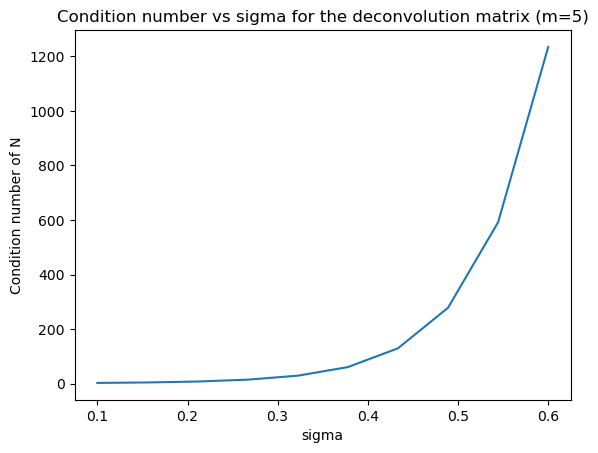

In [16]:
# Compute condition number vs sigma
sigmas = np.linspace(0.1, 0.6, 10)
conds = [np.linalg.cond(deconv_matrix(5, s)) for s in sigmas]

# Plot
plt.figure()
plt.plot(sigmas, conds)
plt.xlabel('sigma')
plt.ylabel('Condition number of N')
plt.title('Condition number vs sigma for the deconvolution matrix (m=5)')
# note that this gets worse for larger m's
plt.show()

# Testing the VRS deconvolution

## Uniform density

In [397]:
# toy data
d = 4
N = 10000
data = np.random.uniform(-1,1,(N,d))
r_list = [3]*d
m_list = [5]*d

C_e, basis = algorithm_3_deconv(data, r_list, m_list, 0.01)

# shouldn't matter at what point we look (uniform density)
z_test = (0.1, -0.5, 0.8, .4)

# would expect to be approx 1/2^d because this the volume, uniform density
print("Estimated density at", z_test, "=", eval_density(C_e, basis, z_test))
print("Expected density: ", 1/2**d)

Estimated density at (0.1, -0.5, 0.8, 0.4) = 0.06137134579213472
Expected density:  0.0625


## Gaussian

In [446]:
def generate_toy_data(N=10000, d=2, sigma=0.5, seed=42):
    """
    Generates toy data for testing the deconvolution algorithm without clipping:
    - True latent Z ~ mixture of two Gaussians on [-1,1]^d.
    - Observed Z* = Z + Gaussian noise N(0, sigma^2).
    Uses rejection sampling to ensure all Z* points lie in [-1,1]^d.
    
    Returns:
    - data_obs: (N, d) array of noisy observations (all within [-1,1]^d).
    - data_true: (N, d) array of true latent values.
    """
    np.random.seed(seed)
    means = [(-0.5, 0.5), (0.5, -0.5)]
    cov = 0.03 * np.eye(d)
    data_true = []
    data_obs = []
    
    while len(data_obs) < N:
        # sample one latent point
        label = np.random.choice([0, 1])
        z = np.random.multivariate_normal(means[label], cov)
        # if latent is outside [-1,1], reject and continue
        if np.any(z < -1) or np.any(z > 1):
            continue
        # add noise
        z_star = z + np.random.normal(0, sigma, size=d)
        # reject if noisy obs is outside [-1,1]
        if np.any(z_star < -1) or np.any(z_star > 1):
            continue
        
        data_true.append(z)
        data_obs.append(z_star)
    
    return np.array(data_obs), np.array(data_true)

In [455]:
def true_density_toy(sample_points):
    sample_points = np.atleast_2d(sample_points)
    M, d = sample_points.shape

    # Four mixture component means in 4D
    means = [(-0.5, 0.5), (0.5, -0.5)]
    cov = 0.03 * np.eye(d)

    # Build one scipy Gaussian object per component
    comps = [multivariate_normal(mean=m, cov=cov) for m in means]

    densities = np.zeros(M)
    for comp in comps:
        densities += (1/4) * comp.pdf(sample_points)

    # Enforce zero outside [-1,1]^4
    out_of_bounds = np.logical_or(sample_points < -1, sample_points > 1).any(axis=1)
    densities[out_of_bounds] = 0.0

    return densities

In [448]:
# Generate the data
data_obs, data_true = generate_toy_data()

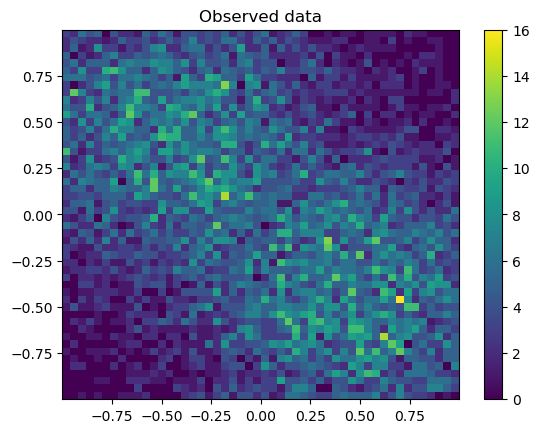

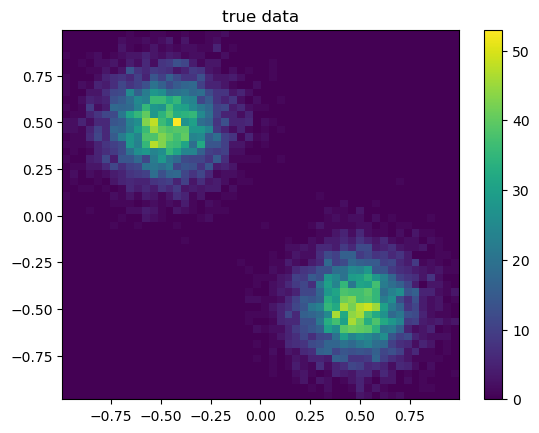

In [449]:
plt.hist2d(data_obs[:,0],data_obs[:,1], bins = 50);
plt.title('Observed data')
plt.colorbar()
plt.show()

plt.hist2d(data_true[:,0],data_true[:,1], bins = 50);
plt.title('true data')
plt.colorbar()
plt.show()

In [450]:
d = 2

# Getting the densities using VRS
r_list = [3]*d   # truncation level (range dimension)
m_list = [5]*d   # basis size per dimension

# Run algorithm 3
C_e, basis = algorithm_3(data_obs, r_list, m_list)
C_e_deconv, basis_deconv = algorithm_3_deconv(data_obs, r_list, m_list, 0.5, 0.015)

In [451]:
# two coordinates we want to visualize
slice1, slice2 = 0,1

fixed_val = 0.0
grid_size = 100

In [452]:
# prepare 2D grid for axes (slice1, slice2)
x = np.linspace(-1, 1, grid_size)
y = np.linspace(-1, 1, grid_size)
X, Y = np.meshgrid(x, y)
grid_points_sliced = np.vstack([X.ravel(), Y.ravel()]).T   # (grid_size**2, 2)

# Embed into d-dimensions by fixing all other coords
full_points = np.full((grid_size*grid_size, d), fixed_val)
full_points[:, slice1] = grid_points_sliced[:, 0]
full_points[:, slice2] = grid_points_sliced[:, 1]

In [453]:
# evaluating VRS on these points

density_vrs = np.array([
    eval_density(C_e, basis, z) 
    for z in full_points
])
density_vrs = density_vrs.reshape(grid_size, grid_size)

# Set any negative values to 0, ad hoc, should fix
density_vrs[density_vrs < 0] = 0


# evaluating VRS on these points

density_vrs_deconv = np.array([
    eval_density(C_e_deconv, basis_deconv, z) 
    for z in full_points
])
density_vrs_deconv = density_vrs_deconv.reshape(grid_size, grid_size)

# Set any negative values to 0, ad hoc, should fix
density_vrs_deconv[density_vrs_deconv < 0] = 0

In [472]:
# getting the true density

dtrue = true_density_toy(pts)
dtrue = dtrue.reshape(grid_size, grid_size)

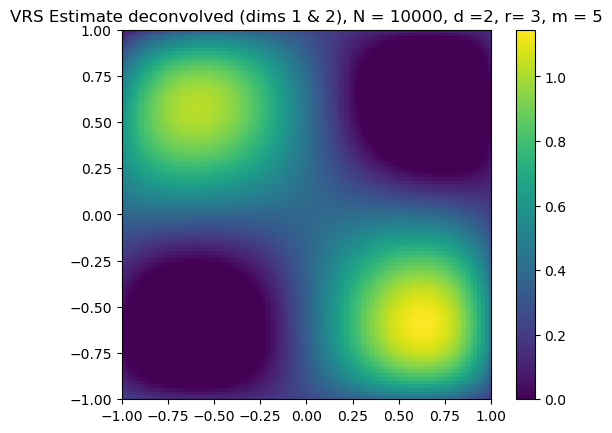

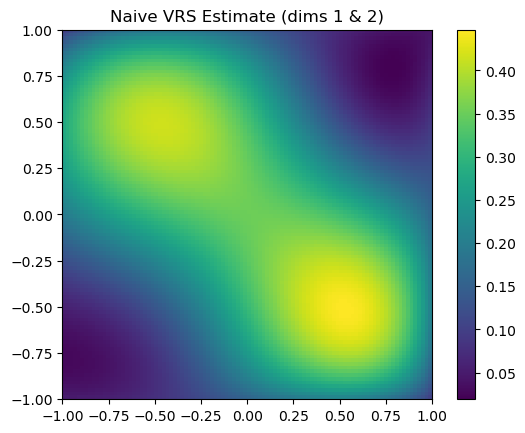

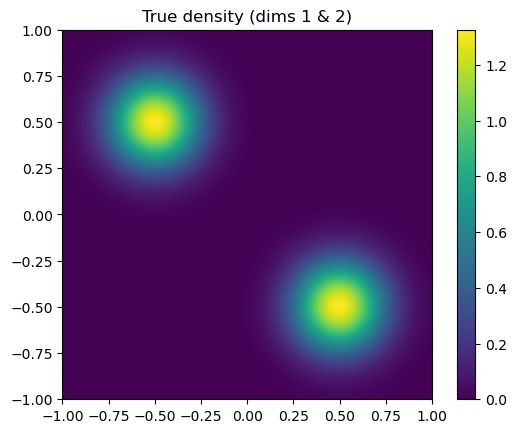

In [478]:
# Plot on scaled axes
extent = [-1, 1, -1, 1]

plt.figure(); 
plt.imshow(density_vrs_deconv, extent=extent, origin='lower')
plt.title(f'VRS Estimate deconvolved (dims {slice1+1} & {slice2+1}), N = {N}, d ={2}, r= {r_list[0]}, m = {m_list[0]}');
plt.colorbar()

plt.figure(); 
plt.imshow(density_vrs, extent=extent, origin='lower')
plt.title(f'Naive VRS Estimate (dims {slice1+1} & {slice2+1})'); 
plt.colorbar()

plt.figure();
plt.imshow(dtrue, extent=extent, origin='lower')
plt.title(f'True density (dims {slice1+1} & {slice2+1})'); 
plt.colorbar()

### Testing error

In [476]:
M = 50000
rng = default_rng(123)
pts_mc = rng.uniform(-1,1,(M, 2))
domain_vol = 2**2

f_vrs_naive = lambda pts: np.array([eval_density(C_e, basis, z) for z in pts])
f_vrs_deconv = lambda pts: np.array([eval_density(C_e_deconv, basis_deconv, z) for z in pts])

err_naive = relative_L2_error(
    f_vrs_naive,
    true_density_toy,
    pts_mc,
    domain_vol
)

err_deconv = relative_L2_error(
    f_vrs_deconv,
    true_density_toy,
    pts_mc,
    domain_vol
)


print(f"Relative L2 error (Naive VRS):      {err_naive:.4f}")
print(f"Relative L2 error (Deconvolved VRS): {err_deconv:.4f}")

Relative L2 error (Naive VRS):      0.8651
Relative L2 error (Deconvolved VRS): 1.2739


In [481]:
# 1) Evaluate raw f_est on MC points
vals_est_raw = f_vrs_deconv(pts_mc)     # shape (M,)
# 2) Force nonnegativity if you like
vals_est_raw = np.maximum(vals_est_raw, 0)
# 3) Estimate the normalization constant by MC
#    ∫_{[-1,1]^2} f_est(z) dz  ≈  (area) * mean(vals_est_raw)
estimated_norm = domain_vol * np.mean(vals_est_raw)

# 4) Define a properly normalized estimator:
vals_est = vals_est_raw / estimated_norm

# 5) Now compare to f_true
vals_true = true_density_toy(pts_mc)   # shape (M,)

# 6) Compute squared‐error integrals via MC
sq_diff = (vals_est - vals_true)**2
sq_true = vals_true**2

int_diff  = domain_vol * np.mean(sq_diff)
int_true  = domain_vol * np.mean(sq_true)
rel_L2 = np.sqrt(int_diff / int_true)


In [482]:
rel_L2

0.7952304601599589

## Copied from other notebook

In [33]:
def generate_data(N, d, mean, std, noise_std = 0.2, rng=None):
    if rng is None:
        rng = np.random.default_rng()

    # Pre-allocate the output array once
    data = np.empty((N, d), dtype=float)
    count = 0

    batch_size = 1024  # you can tune this up/down (powers of two are fine)

    while count < N:
        # 1) Draw a batch of “true” points and noise
        pts = rng.normal(mean, std, size=(batch_size, d))
        noise = rng.normal(loc=0, scale=noise_std, size=(batch_size, d))
        pts_obs = pts + noise

        # 2) Mask: keep only those whose noisy coords are all in [-1, 1]
        mask = np.all((pts_obs >= -1) & (pts_obs <= 1), axis=1)
        accepted = pts_obs[mask]  # shape = (nb_accepted_in_this_batch, d)

        # 3) Copy up to (N − count) of these “accepted” into our pre-allocated array
        if accepted.shape[0] > 0:
            remaining = N - count
            take = min(accepted.shape[0], remaining)
            data[count : count + take, :] = accepted[:take]
            count += take

    return data

In [20]:
def true_gaussian_density(mean, std):
    """Return a function f_true(pts) for pts (M,d)."""
    rng = default_rng()
    def f_true(pts):
        # unnormalized Gaussian
        vals = np.exp(-0.5 * np.sum(((pts - mean)/std)**2, axis=1))
        # compute normalization constant Z by Monte Carlo once
        return vals / const
    # estimate normalization constant Z = ∫_{[-1,1]^d} e^{-...} dx
    # via a quick MC
    MC = rng.uniform(-1,1,(200000, len(mean)))
    vals = np.exp(-0.5 * np.sum(((MC - mean)/std)**2, axis=1))
    const = np.mean(vals) * (2**len(mean))
    return f_true

In [120]:
mean = [0.5]*2
std  = 0.2 * np.ones(2)
# generate truncated Gaussian in d dims
data = []
obs_data = []

rng = default_rng(10)
while len(obs_data) < 100000:
    pts = rng.normal(mean, std, size=(1, 2))
    mask = np.all((pts >= -1) & (pts <= 1), axis=1)
    data.extend(pts[mask])

    pts_obs = np.array([pts[0][0] + np.random.normal(loc=0, scale=0.4), pts[0][1] + np.random.normal(loc=0, scale=0.4)])
    mask = np.all((pts_obs >= -1) & (pts_obs <= 1))
    obs_data.extend(pts_obs[mask])

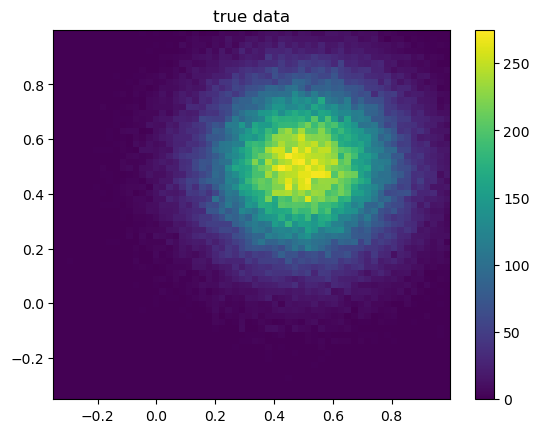

Text(0.5, 1.0, 'observed data')

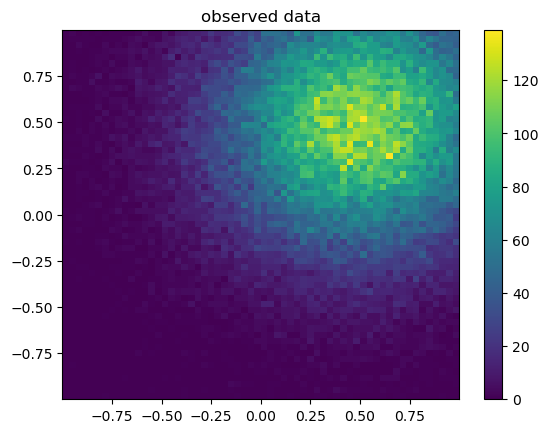

In [121]:
plt.hist2d(np.array(data)[:,0],np.array(data)[:,1], bins=60);
plt.colorbar()
plt.title('true data')
plt.show()

plt.hist2d(np.array(obs_data)[:,0],np.array(obs_data)[:,1], bins=60);
plt.colorbar()
plt.title('observed data')

In [75]:
mean = [0.5]*2
std  = 0.2 * np.ones(2)
# generate truncated Gaussian in d dims
data = []

rng = default_rng(10)
while len(data) < 10000:
    pts = rng.normal(mean, std, size=(1, 2))

    pts_obs = np.array([pts[0][0] + np.random.normal(loc=0, scale=0.4), pts[0][1] + np.random.normal(loc=0, scale=0.4)])
    mask = np.all((pts_obs >= -1) & (pts_obs <= 1))
    data.extend(pts_obs[mask])

In [83]:
pts = rng.normal(mean, std, size=(1, 3))

In [98]:
d=2
data = []
    
rng = default_rng(10)
while len(data) < N:
    pts = rng.normal(mean, std, size=(1, d))

    pts_obs = pts + np.random.normal(loc=0, scale=0.4, size=d)
    mask = np.all((pts_obs >= -1) & (pts_obs <= 1))
    data.extend(pts_obs[mask])

In [44]:
N = 100000
results = []

for d in [2, 3, 4, 5, 6]:
    mean = [0.5]*d
    std  = 0.2 * np.ones(d)
    noise_std = 0.3
    # generate truncated Gaussian in d dims
    data = []
    
    rng = default_rng(10)
    data = generate_data(N, d, mean, std, noise_std = noise_std)

    # Fit VRS
    r_list = [1]*d
    m_list = [12]*d
        
    C_e, basis = algorithm_3(data, r_list, m_list)
    C_e_deconv, basis_deconv = algorithm_3_deconv(data, r_list, m_list, noise_std, alpha = 0.01)

    # Build estimators
    f_naive = lambda pts: np.maximum(0, np.array([eval_density(C_e, basis, z) for z in pts]))
    f_deconv = lambda pts: np.maximum(0, np.array([eval_density(C_e_deconv, basis_deconv, z) for z in pts]))

    # Monte Carlo points for error
    M = 50000
    pts_mc = rng.uniform(-1,1,(M, d))
    domain_vol = 2**d

    # True density
    f_true = true_gaussian_density(mean, std)

    # compute relative L2 errors
    err_naive = relative_L2_error(f_naive, f_true, pts_mc, domain_vol)
    err_deconv = relative_L2_error(f_deconv, f_true, pts_mc, domain_vol)

    results.append((d, err_naive, err_deconv))
    print(f"{d}: Naive = {err_naive:.4f}, Deconvolved = {err_deconv:.4f}")

2: Naive = 0.5519, Deconvolved = 0.2661
3: Naive = 0.6728, Deconvolved = 0.3135
4: Naive = 0.7491, Deconvolved = 0.3529
5: Naive = 0.8238, Deconvolved = 0.3915


KeyboardInterrupt: 

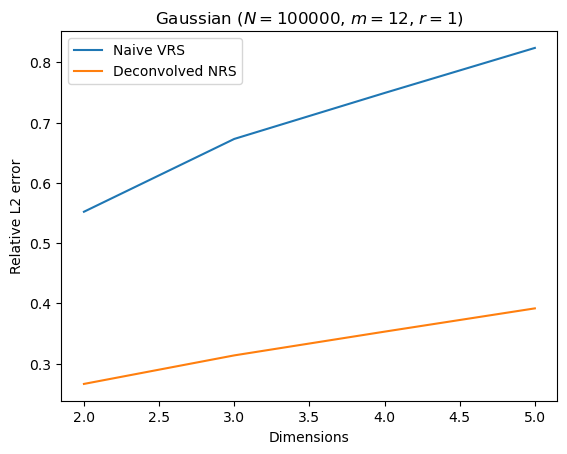

In [45]:
plt.plot(np.array(results)[:,0], np.array(results)[:,1], label = 'Naive VRS')
plt.plot(np.array(results)[:,0], np.array(results)[:,2], label = 'Deconvolved VRS')
plt.xlabel('Dimensions')
plt.ylabel('Relative L2 error')
plt.title(f'Gaussian ($N={N}$, $m={m_list[0]}$, $r={r_list[0]}$)')
plt.legend();

# Trying it on KDE

In [49]:
# Generating the 2D Gaussian data

N = 10000
means = [0.5, -0.4]
stds = [0.4, 0.4]
true_data = np.random.multivariate_normal(means, np.diag(np.square(stds)), size=N)

In [51]:
# Add Gaussian noise
sigma_u = 0.4
noisy_data = true_data + np.random.normal(scale=sigma_u, size=true_data.shape)

In [53]:
#  Deconvolution KDE using Gaussian kernel

h = 0.5  # bandwidth > noise std
var_L = h**2 - sigma_u**2  # variance of deconvolution kernel
assert var_L > 0, "Bandwidth must exceed noise std for deconvolution"
coef = 1.0 / (2 * np.pi * var_L * N)

In [67]:
# Compute density estimate on grid

grid_size = 100
x = np.linspace(-1, 1, grid_size)
Xg, Yg = np.meshgrid(x, x)
density_deconv = np.zeros_like(Xg)

for xi, yi in zip(noisy_data[:, 0], noisy_data[:, 1]):
    density_deconv += np.exp(-((Xg - xi)**2 + (Yg - yi)**2) / (2 * var_L))

density_deconv *= coef

In [68]:
# Naively running KDE on the noisey data

grid_points = np.vstack([Xg.ravel(), Yg.ravel()]).T

kde = gaussian_kde(noisy_data.T)
density_naive = kde(grid_points.T).reshape(grid_size, grid_size)

In [69]:
# True density for comparison
_, _, density_true = d_dim_gaussian_density(means, stds, grid_size=grid_size, i=0, j=1)

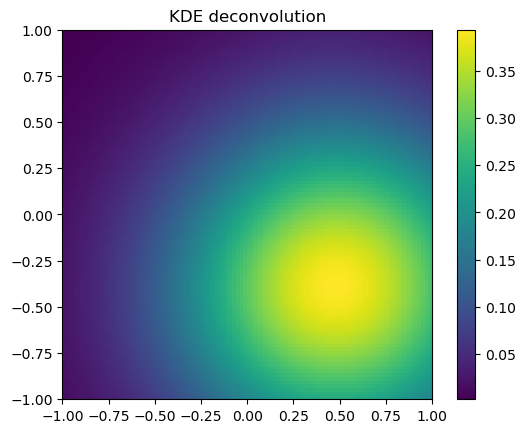

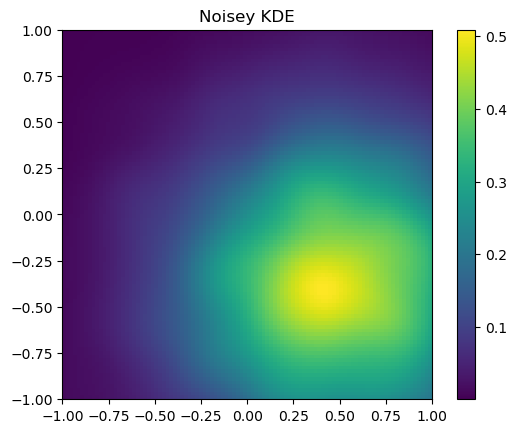

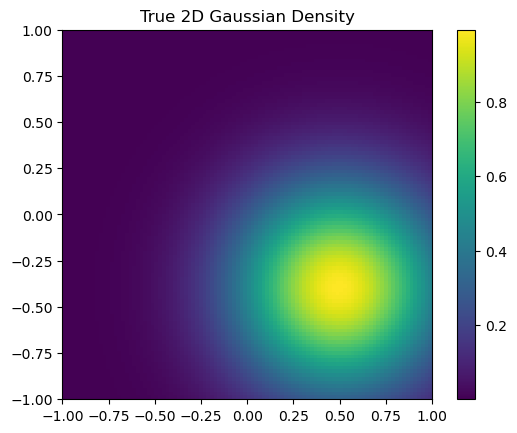

Text(0.5, 1.0, 'Noisy data')

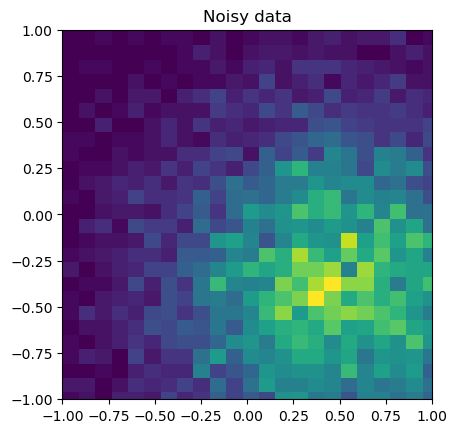

In [81]:
# Plotting

# KDE
plt.imshow(density_est, extent=(-1,1,-1,1), origin='lower', aspect='equal')
plt.title('KDE deconvolution')
plt.colorbar()
plt.show()

# noisey KDE
plt.imshow(density_naive, extent=(-1,1,-1,1), origin='lower', aspect='equal')
plt.title('Noisey KDE')
plt.colorbar()
plt.show()

# True density
plt.imshow(density_true, extent=(-1,1,-1,1), origin='lower', aspect='equal')
plt.title('True 2D Gaussian Density')
plt.colorbar()
plt.show()

# True datapoints
plt.hist2d(noisy_data[:,0], noisy_data[:,1], bins = 50);
plt.xlim([-1,1])
plt.ylim([-1,1])
plt.gca().set_aspect('equal')
plt.title('Noisy data')

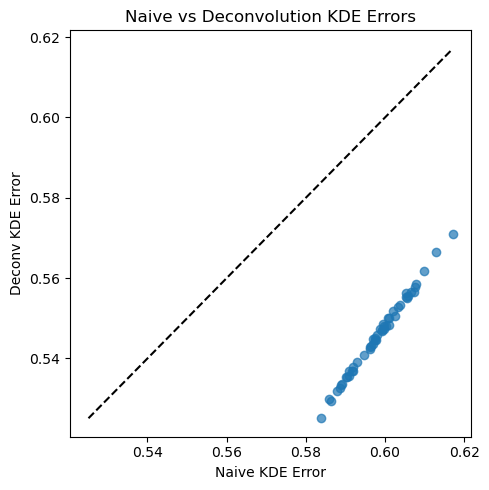

In [79]:
def compute_errors(seed, n_samples=500, grid_size=100, h=0.4, sigma_u=0.2):
    np.random.seed(seed)
    means = [0.0, 0.0]
    stds = [0.3, 0.3]
    
    # Get the true density grid
    Xg, Yg, density_true = d_dim_gaussian_density(means, stds, grid_size)
    dx = dy = 2/(grid_size-1)
    norm_true = np.sqrt(np.sum(density_true**2) * dx * dy)

    # Simulate data
    true_data = np.random.multivariate_normal(means, np.diag(np.square(stds)), size=n_samples)
    noisy_data = true_data + np.random.normal(scale=sigma_u, size=true_data.shape)

    # Naive KDE
    var_naive = h**2
    coef_naive = 1.0/(2*np.pi*var_naive*n_samples)
    density_naive = np.zeros_like(density_true)
    for xi, yi in noisy_data:
        density_naive += np.exp(-((Xg - xi)**2 + (Yg - yi)**2)/(2*var_naive))
    density_naive *= coef_naive
    err_naive = np.sqrt(np.sum((density_naive - density_true)**2) * dx * dy) / norm_true

    # Deconvolution KDE
    var_deconv = h**2 - sigma_u**2
    coef_deconv = 1.0/(2*np.pi*var_deconv*n_samples)
    density_deconv = np.zeros_like(density_true)
    for xi, yi in noisy_data:
        density_deconv += np.exp(-((Xg - xi)**2 + (Yg - yi)**2)/(2*var_deconv))
    density_deconv *= coef_deconv
    err_deconv = np.sqrt(np.sum((density_deconv - density_true)**2) * dx * dy) / norm_true

    return err_naive, err_deconv

# Run multiple trials
trials = 50
results = [compute_errors(seed) for seed in range(trials)]
df = pd.DataFrame(results, columns=['Naive KDE Error', 'Deconv KDE Error'])

# Scatter plot for visualization
plt.figure(figsize=(5,5))
plt.scatter(df['Naive KDE Error'], df['Deconv KDE Error'], alpha=0.7)
plt.plot([df.min().min(), df.max().max()], [df.min().min(), df.max().max()], 'k--')
plt.xlabel('Naive KDE Error')
plt.ylabel('Deconv KDE Error')
plt.title('Naive vs Deconvolution KDE Errors')
plt.tight_layout()
plt.show()